## A quantum lie detector for Hardy's paradox

Hello! I'm Maria and I've been using Qiskit to understand quantum paradoxes. If you haven't already, take a look at my video "[Quantum Lie Detector: How to Win Two Truths and a Lie](https://www.youtube.com/watch?v=kLdvDDHLvOA)" on the Qiskit YouTube channel or my blog post "[How to Build a Quantum Lie Detector with Quantum Computers](https://qisk.it/3LcdmVs)" on the Qiskit Medium blog. There, I explain Hardy's paradox, which shows how classical reasoning breaks down for entangled particles. This was proposed to show a new type of quantum spooky-action-at-a-distance, also known as non-locality, in a stronger way than using Bell inequalities (Again, if you aren’t familiar with these terms, be sure to read my [blog post](https://medium.com/qiskit/how-to-build-a-quantum-lie-detector-with-quantum-computers-464d6456c5ec). 

In this Jupyter notebook, I'm going to show you the code to build a quantum lie detector using Qiskit, so you can see for yourself where the classical reasoning breaks down. 

Let's play a game of two quantum truths and a lie. Imagine we have two entangled qubits in the state |00> + |01> + |10>, and I give one to Alice and one to Bob. Then Carol tells us three statements about the outcomes that Alice and Bob will get when they measure their qubits. Two of these are true, and one is a lie. You can check each of Carol's statements using the quantum lie detector. 

![Alice_Bob_Carol](new_Alice_Bob_Carol.png)

You can input whether Alice and Bob measure in their qubits in the x-basis or z-basis, and a measurement outcome that Carol thinks should be forbidden.

1. If Alice and Bob both measure their qubits in the z-basis, the outcome |11> is forbidden.

Run the code for the Quantum Lie Detector below, and input "z" for Alice's basis, "z" for Bob's basis, and "11" for the forbidden outcome. You will find that the statement is true. 

Now Carol's second statement: 

2. If Alice measures in z- and Bob measures in x-, the |0 -> state is forbidden. And vice-versa: if Alice measures in x- and Bob in z-, |-0> is forbidden. 

For the x-basis measurements, an outcome of 0 corresponds to |+> before measurement, and 1 corresponds to |->. So when Alice measures in z and Bob measures in x, |01> is forbidden. Now try checking this - it's true! And if Bob measures in z, and Alice in x, then |10> should be forbidden, which is also true. 

Now you can test Carol's final statement.

3. If Alice and Bob both measure in the x-basis, then the |--> state is forbidden. 

This corresponds to an x-measurement outcome of |11> being forbidden. 

Have a go at checking this - it is a lie! 

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np
from qiskit.providers.aer import QasmSimulator
simulator = QasmSimulator()

In [ ]:
# Quantum lie detector

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np
from qiskit.providers.aer import QasmSimulator
simulator = QasmSimulator()

hardy_circuit = QuantumCircuit(2)
hardy_circuit.initialize(np.array([1, 1, 1, 0])/np.sqrt(3))
hardy_circuit.measure_all()

def truth_lie(alice, bob) -> QuantumCircuit:
    qr = QuantumRegister(2, 'q')
    cr = ClassicalRegister(2, 'c')
    qc = QuantumCircuit(qr, cr)
    
    hardy_circuit.initialize(np.array([1, 0, 1, 1])/np.sqrt(3))
    
    if alice == "x": 
        qc.h(0)
    if bob == "x":
        qc.h(1)
    qc.measure(qr[0],cr[0])
    qc.measure(qr[1],cr[1])
    return qc

a = input("What basis does Alice measure in? Type z for z-basis, or x for x-basis.")
b = input("What basis does Bob measure in? Type z for z-basis, or x for x-basis.")

truth_lie = truth_lie(a,b)

truth_lie_job = simulator.run(truth_lie, shots=1000)
truth_lie_result = truth_lie_job.result()
truth_lie_counts = truth_lie_result.get_counts(truth_lie)

result = sorted(truth_lie_counts.keys())

guess = input("Which state will never occur?")

toggle = 0 

for i in range(len(result)):
    if result[i]== guess: 
        print("The statement was a LIE.")
        print("There is finite chance of the result:")
        print(guess)
        toggle = 1
        
if toggle == 0: 
    print("The statement was a TRUTH.")
    print("There is no chance of the result:")
    print(guess)

Carol's quantum lie is at the root of Hardy's paradox, which was proposed in 1992 by Lucien Hardy. I'm going to explain how Hardy's original paradox can be mapped onto Carol's three statements, and how these translate to the quantum circuits I used to build my quantum lie detector.

Hardy's original thought experiment involved two overlapping interferometers - which can split particles into a superposition of states, and merge them back into one state again. We then pass a particle through one of the interferometers and an antiparticle through the other. Where the interferometers overlap, the particle and antiparticle will annihilate each other - and not be detected at the end. Hardy realised that according to quantum theory, there is a finite chance of measuring an outcome that seems to suggest both particles went down the same path, but without annihilating each other - which should be impossible! 

![title](image.png)

We can present the particle and antiparticle as qubits, with 0 being one path down the interferometer, and 1 being the other. Then the joint state of the qubits before they are measured needs to have a term where the particles have both gone down the same path missing - let's say this is the |11> term. So, before the qubits are measured, they are in the state |00> + |01> + |10>. We can create this state using the initialize method in qiskit.

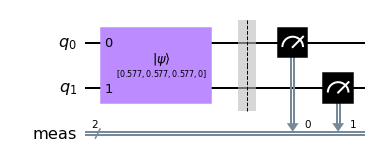

In [2]:
# Preparing the circuit

hardy_circuit = QuantumCircuit(2)
hardy_circuit.initialize(np.array([1, 1, 1, 0])/np.sqrt(3))
hardy_circuit.measure_all()

hardy_circuit.draw(output="mpl")

We can find out the gates needed to create this state on a quantum computer by using the Qiskit transpiler, which shows the z-rotations, root-x gates and C-NOT gates we need.

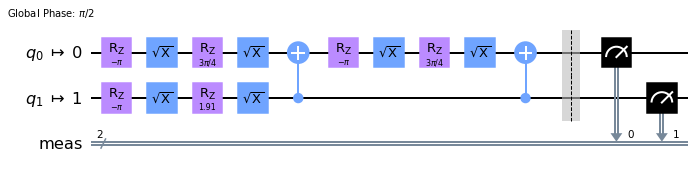

In [3]:
from qiskit import transpile

from qiskit.providers.aer import AerSimulator
from qiskit.test.mock import FakeParis

backend_sim = AerSimulator.from_backend(FakeParis())
transpile(hardy_circuit, backend_sim).draw(output='mpl', idle_wires=False)

Now we give the first qubit to Alice, and the second qubit to Bob (so Alice is detecting the particle and Bob is detecting the antiparticle). 

Carol's first statement says that if Alice and Bob both measure their qubits in the z-basis, then at least one will get 0. We can see this directly from the state we have prepared, |00> + |10> + |01>, and confirm it by looking at the outcomes of running our quantum circuit. There is no 11 term.  

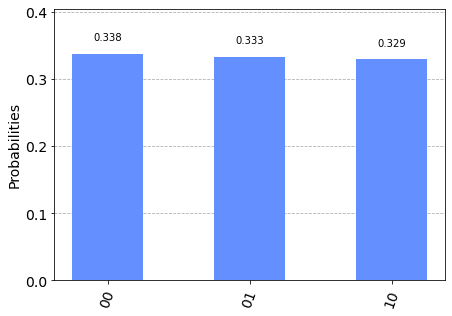

In [4]:
# Running the circuit 

from qiskit.providers.aer import QasmSimulator
simulator = QasmSimulator()

job = simulator.run(hardy_circuit, shots=8000)
result = job.result()
counts = result.get_counts(hardy_circuit)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

Carol's second statement says that if Alice does a z-measurement and gets 0, then Bob must have |+>. This is true since we can write the quantum state as: 

|00> + |10> + |01>

= |0>|+> + |10> 


Similarly, if Bob does a z-measurement and gets 0, then Alice must have |+>, since we can also write the state as: 

|+>|0> + |01>

We can test this out by running a quantum circuit where Alice measures z and Bob measures x. There's no 01 outcome, indicating that every time Alice got 0, Bob got |+>. 

|00> + |10> + |01>

= |0>|+> + |10> 

= |+>|0> + |01>

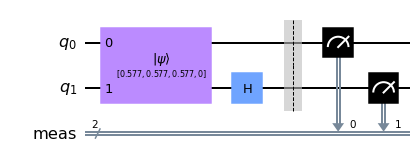

In [5]:
# Alice measures z, Bob measures x

hardy_circuit = QuantumCircuit(2)

hardy_circuit.initialize(np.array([1, 1, 1, 0])/np.sqrt(3))
hardy_circuit.h(1)

hardy_circuit.measure_all()

hardy_circuit.draw(output="mpl")

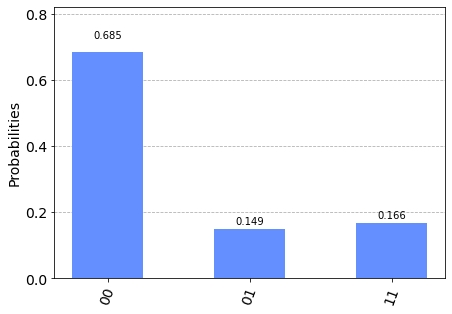

In [6]:
job = simulator.run(hardy_circuit, shots=1000)
result = job.result()
counts = result.get_counts(hardy_circuit)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

Likewise, when we run the circuit with Alice making an x-measurement and Bob making a z-measurement, there is no 10 term: 

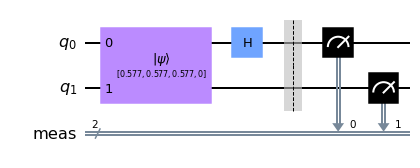

In [7]:
# Alice measures x, Bob measures z

hardy_circuit = QuantumCircuit(2)

hardy_circuit.initialize(np.array([1, 1, 1, 0])/np.sqrt(3))
hardy_circuit.h(0)

hardy_circuit.measure_all()

hardy_circuit.draw(output="mpl")

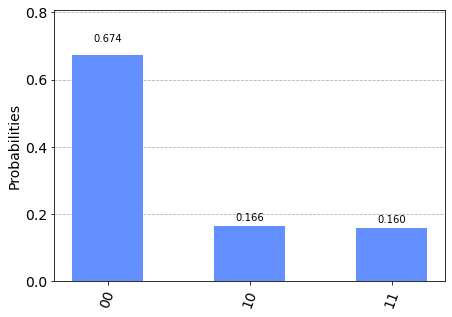

In [8]:
job = simulator.run(hardy_circuit, shots=1000)
result = job.result()
counts = result.get_counts(hardy_circuit)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

Now what if we put our conclusions from these two quantum circuits together? We know at least one person—either Alice or Bob—would get 0 if we measure them in the z-basis, and we know that if one of them measures 0 in the z-basis, then the other must have |+>. Classical Carol's intuitive conclusion was that at least one of Alice and Bob's qubits must be in the |+> state. So now let's see what happens if we let them both do x-basis measurements, and run the circuit. 

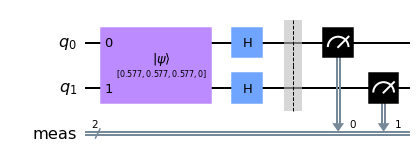

In [9]:
# Alice measures x, Bob measures x

hardy_circuit = QuantumCircuit(2)

hardy_circuit.initialize(np.array([1, 1, 1, 0])/np.sqrt(3))
hardy_circuit.h(0)
hardy_circuit.h(1)

hardy_circuit.measure_all()

hardy_circuit.draw(output="mpl")

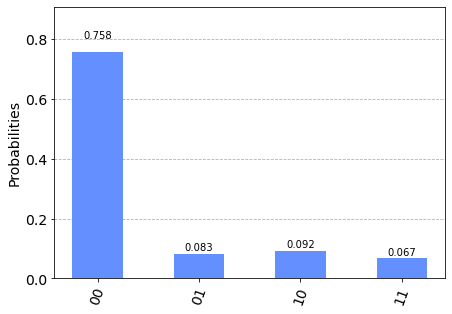

In [10]:
job = simulator.run(hardy_circuit, shots=1000)
result = job.result()
counts = result.get_counts(hardy_circuit)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

We have a problem! There is some chance that we measure the outcome 11, corresponding to the |--> state, which contradicts our conclusion! 

This contradiction has drastic physical consequences in Hardy's original setup. According to classical Carol, we can only get the |--> state if neither Alice nor Bob would have got 0 if measured in the z-basis. This implies that the qubits were in the |11> state, which we said corresponds to a particle and antiparticle having gone down the same path, which is impossible - they should have annhililated each other.

Hardy pointed out that Carol made an important classical assumption when she deduced that at least one person, either Alice or Bob, would get |+>. She assumed that Alice measuring her qubit will make no difference to Bob's qubit, which would be true classically. One resolution to the paradox is that Alice choosing to make an z-basis or x-basis measurement actually "non-locally" affects Bob's measurement outcomes, and vice-versa. However, the correct way of understanding the solution to the paradox, and the physical meaning of non-locality more generally, remains under debate.  

So our game of two quantum truths and a lie reveals some strange quantum truths about non-locality. And this doesn't just work for the special entangled state I used for my game, but almost all entangled qubits. Can you create your own quantum lie detector, to tell the difference between two truths and a classically convincing lie?